# Algoithmic Fairness, Accountability and Ethics
## Assignment 2 (Template)

In [1]:
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import scipy.optimize as opt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.contingency import association
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split

### 1. Load and Preprocess the data
We are going to work with the [Folktables](https://github.com/socialfoundations/folktables#quick-start-examples) dataset (*you have already worked with it*).

1. As last week, we are still predicting the *Total person's income*  (I've digitized  it in  `target_transform=lambda x: x > 25000`).
2. Today, we are going to implement two methods for data debiasing: [Fair PCA](https://deepai.org/publication/efficient-fair-pca-for-fair-representation-learning) and [A Geometric Solution to Fair Representations](https://dl.acm.org/doi/10.1145/3375627.3375864).
3. We are going to evaluate the performance on two sensitive features: `SEX` (i.e. *Males* and *Females*) and `RAC1P` (we will consider only *Whites* and *African-Americans*)
4. I updated the filtering method `adult_filter` to keep the specified groups.

In [2]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP', # Age
        'COW', # Class of worker i.e private for profit, gov, non-profit
        'SCHL', # Education
        'MAR', # marriage status
        'CIT', # citizenship status
        'RELP', # relationship to reference person
        'WKHP', # hours worked per week
        'PWGTP', # weight
        'SEX', # 1. male 2. female
        'RAC1P'# 1. white, 2 black
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', "RAC1P"],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [3]:
features, target, protected = ACSIncomeNew.df_to_pandas(acs_data)
features_old = features.copy()

In [4]:
features = features.loc[features.index.repeat(features_old.PWGTP)].reset_index(drop=True).drop('PWGTP', axis=1)
target = target.loc[target.index.repeat(features_old.PWGTP)].reset_index(drop=True)
protected = protected.loc[protected.index.repeat(features_old.PWGTP)].reset_index(drop=True)

In [5]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, target, protected, test_size=0.3, random_state=0, shuffle=True)

In [6]:
N = 500

X_train = X_train[:N]
y_train = y_train[:N]
group_train = group_train[:N]
X_test = X_test[:N]
y_test = y_test[:N]
group_test = group_test[:N]

## Task 1

In [52]:
import seaborn as sns

for cat in ['SEX', 'RAC1P']:
    for i in range(1,3):
        print(f"{cat} {i} count:",len(group_train[group_train[cat] == i]))



SEX 1 count: 268
SEX 2 count: 232
RAC1P 1 count: 460
RAC1P 2 count: 40


In [7]:
import seaborn as sns

for cat in ['SEX', 'RAC1P']:
    for i in range(1,3):
        print(f"{cat} {i} count:",len(group_train[group_train[cat] == i]))



SEX 1 count: 273
SEX 2 count: 227
RAC1P 1 count: 459
RAC1P 2 count: 41


In [53]:
males = group_train[group_train['SEX'] == 1]
females = group_train[group_train['SEX'] == 2]

for i in range(1,3):
    print(f"Male race {i}", len(males[males['RAC1P'] == i]))
    print(f"Female race {i}", len(females[females['RAC1P'] == i]))

Male race 1 246
Female race 1 214
Male race 2 22
Female race 2 18


In [8]:
males = group_train[group_train['SEX'] == 1]
females = group_train[group_train['SEX'] == 2]

for i in range(1,3):
    print(f"Male race {i}", len(males[males['RAC1P'] == i]))
    print(f"Female race {i}", len(females[females['RAC1P'] == i]))

Male race 1 249
Female race 1 210
Male race 2 24
Female race 2 17


### Bias in Training Data
We find around 10% more men than women in our training data, and more than 11 times more Whites than African-Americans (!)

## 1.2 Proxies

Looking at the distribution of features for each gender, a model could potentially use low weight < ~50 as a proxy variable for woman and a high amount of working hours as a proxy for male.

 ### 1.2.1 Visualisations

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


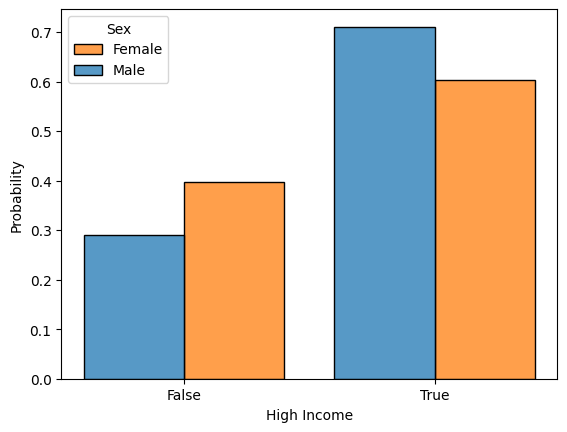

In [51]:
g = sns.histplot(data=X_train.assign(PINCP=y_train, SEX=np.where(X_train['SEX'] == 1, 'Male', 'Female')), x='PINCP', hue='SEX', multiple="dodge", common_norm=False, shrink=0.8, discrete=True, stat='probability')
g.legend(labels=['Female', 'Male'], title='Sex')
g.set_xlabel('High Income')
g.set_xticks([0,1], labels=['False', 'True'])
plt.show()

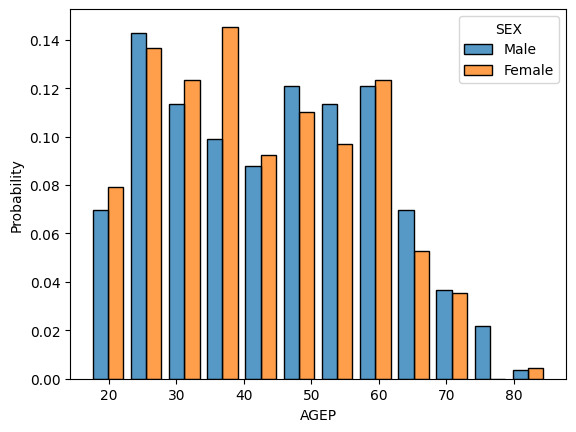

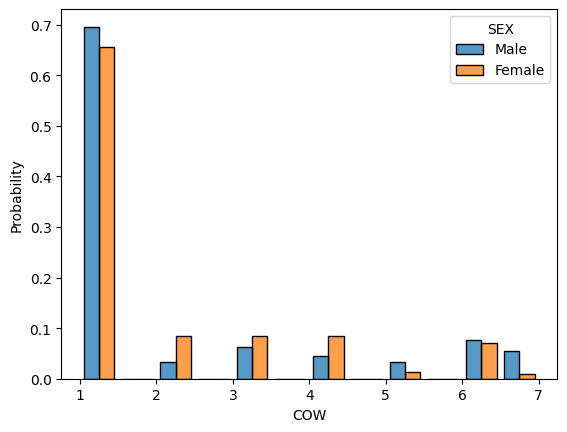

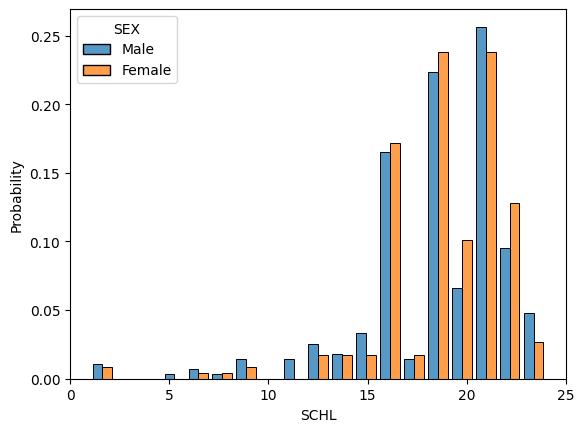

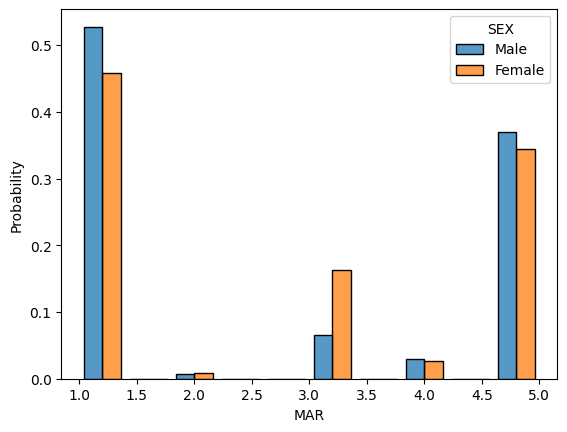

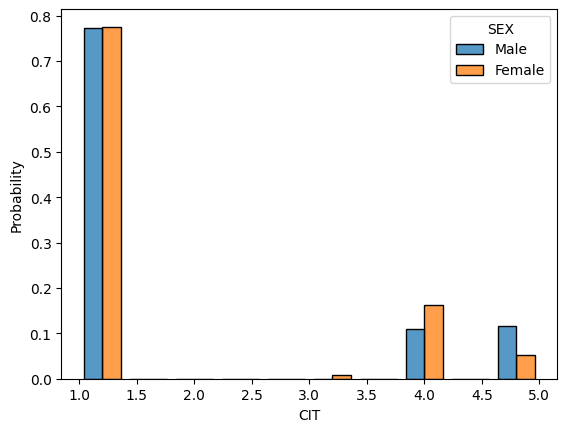

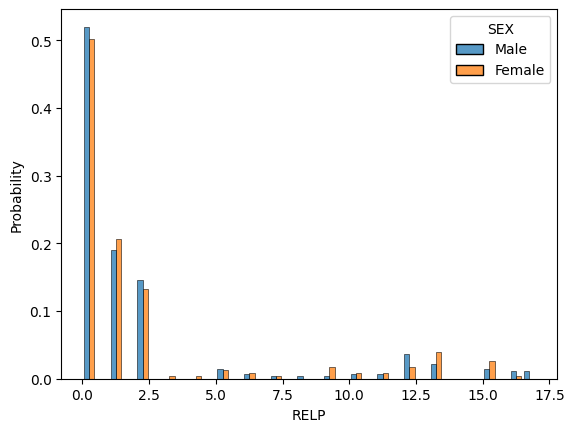

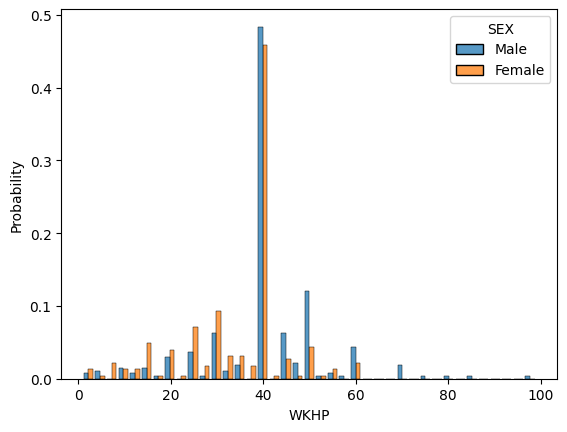

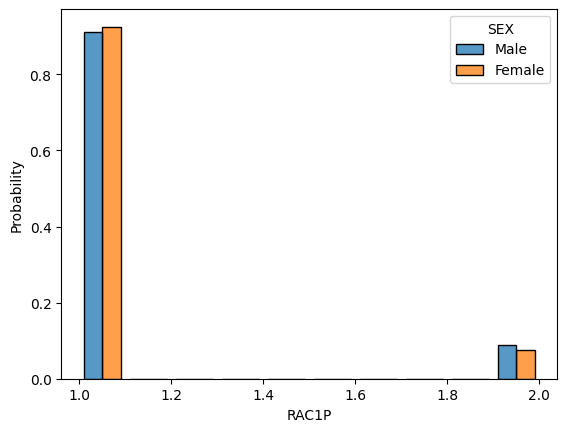

In [10]:
for feature in X_train.drop(['SEX'], axis=1).columns:
    sns.histplot(data=X_train.assign(SEX=np.where(X_train['SEX'] == 1, 'Male', 'Female')), x=feature, hue='SEX', multiple="dodge", common_norm=False, shrink=0.8, stat='probability')

    plt.show()

 ### 1.2.2 correlations

In [30]:
# Age and Sex
# association(np.array(features[["AGEP","SEX"]], dtype=int))
# Sex and income
print("Sex and Income",pointbiserialr(X_train["SEX"]-1, y_train))
# Sex and age
print("Sex and Age",pointbiserialr(X_train["SEX"]-1, X_train["AGEP"]))
# Sex and school
print("Sex and school",pointbiserialr(X_train["SEX"]-1, X_train["SCHL"]))
# Sex and marriage status
print("Sex and marriage status cramerv",round(association(np.array(X_train[["SEX","MAR"]], dtype=int)),3))
# Sex and Work class
print("Sex and work class cramerv",round(association(np.array(X_train[["SEX","COW"]], dtype=int)),3))
# Sex and citizenship status
print("Sex and citizen status cramerv",round(association(np.array(X_train[["SEX","CIT"]], dtype=int)),3))
# Sex and hours worked per week
print("Sex and Work Hours",pointbiserialr(X_train["SEX"]-1, X_train["WKHP"]))

Sex and Income PointbiserialrResult(correlation=array([-0.11272499282366444], dtype=object), pvalue=0.011657606239511595)
Sex and Age PointbiserialrResult(correlation=-0.06079548025472804, pvalue=0.17469178249305992)
Sex and school PointbiserialrResult(correlation=0.05382027538198347, pvalue=0.22962839293487308)
Sex and marriage status cramerv 0.363
Sex and work class cramerv 0.394
Sex and citizen status cramerv 0.375
Sex and Work Hours PointbiserialrResult(correlation=-0.2321764339581578, pvalue=1.5164939411209122e-07)


In [31]:
# Age and Sex
# association(np.array(features[["AGEP","SEX"]], dtype=int))
# Race and income
print("Race and Income",pointbiserialr(X_train["RAC1P"]-1, y_train))
# Race and age
print("Race and Age",pointbiserialr(X_train["RAC1P"]-1, X_train["AGEP"]))
# Race and school
print("Race and school",pointbiserialr(X_train["RAC1P"]-1, X_train["SCHL"]))
# Race and marriage status
print("Race and marriage status cramerv",round(association(np.array(X_train[["RAC1P","MAR"]], dtype=int)),3))
# Race and Work class
print("Race and work class cramerv",round(association(np.array(X_train[["RAC1P","COW"]], dtype=int)),3))
# Race and citizenship status
print("Race and citizen status cramerv",round(association(np.array(X_train[["RAC1P","CIT"]], dtype=int)),3))
# Race and hours worked per week
print("Race and Work Hours",pointbiserialr(X_train["RAC1P"]-1, X_train["WKHP"]))

Race and Income PointbiserialrResult(correlation=array([-0.07924036299017381], dtype=object), pvalue=0.07669083287422425)
Race and Age PointbiserialrResult(correlation=-0.08121970225136416, pvalue=0.06958832198796683)
Race and school PointbiserialrResult(correlation=-0.03100387990935344, pvalue=0.48912640002870605)
Race and marriage status cramerv 0.323
Race and work class cramerv 0.359
Race and citizen status cramerv 0.345
Race and Work Hours PointbiserialrResult(correlation=0.0337962009616282, pvalue=0.450831206143433)


### 1.2.3

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


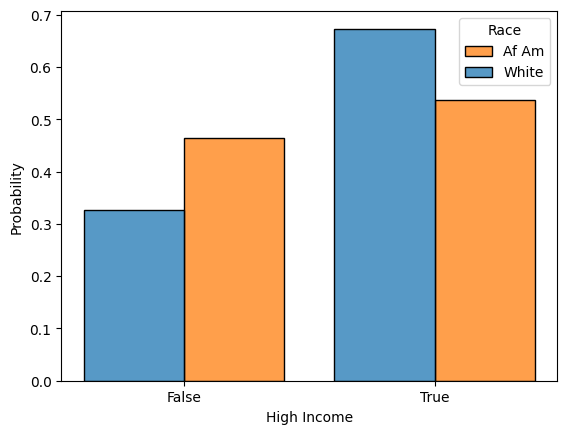

In [50]:
g = sns.histplot(data=X_train.assign(PINCP=y_train, RAC1P=np.where(X_train['RAC1P'] == 1, 'White', 'AfAm')), x='PINCP', hue='RAC1P', multiple="dodge", common_norm=False, shrink=0.8, discrete=True, stat='probability')
g.legend(labels=['Af Am', 'White'], title='Race')
g.set_xlabel('High Income')
g.set_xticks([0,1], labels=['False', 'True'])
plt.show()

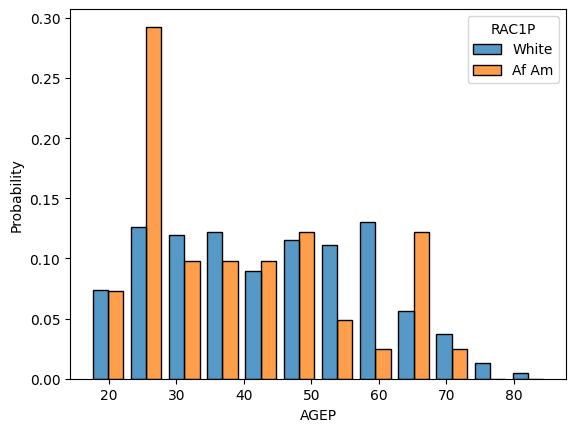

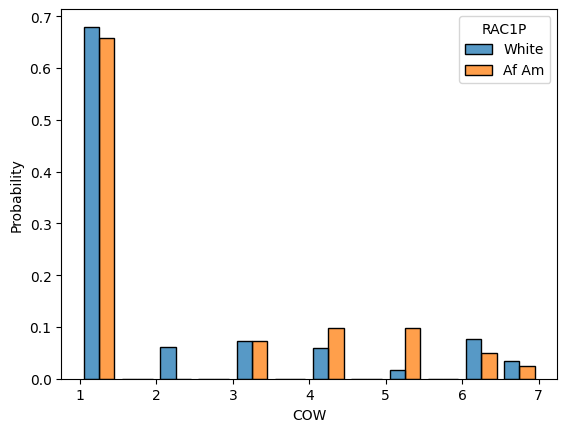

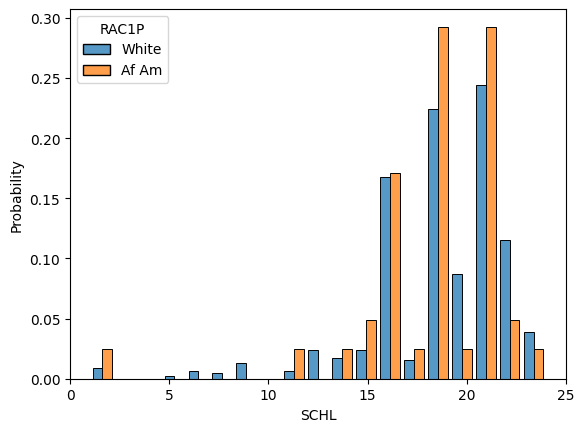

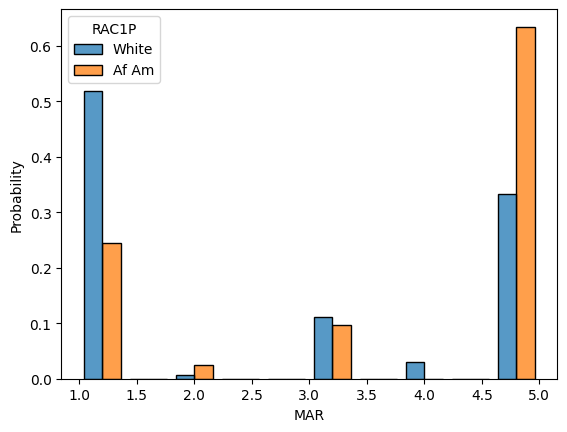

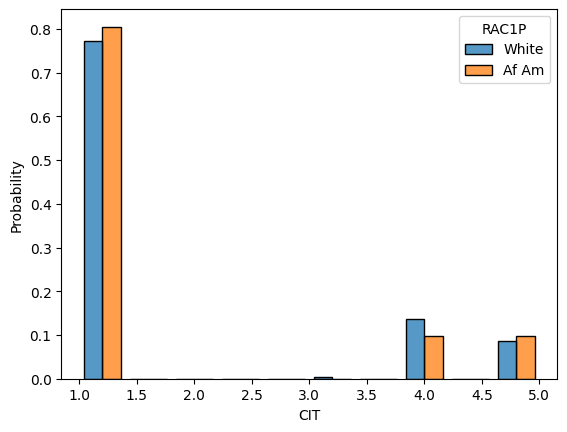

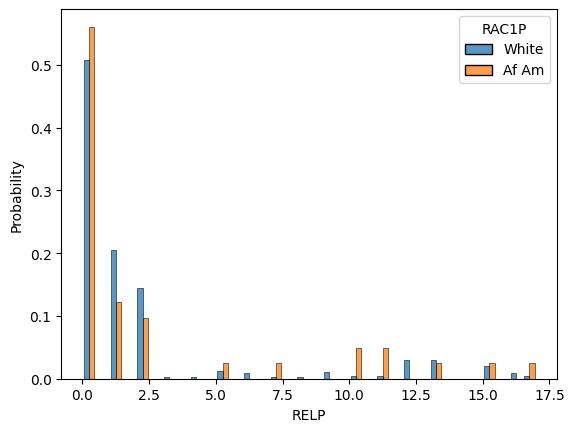

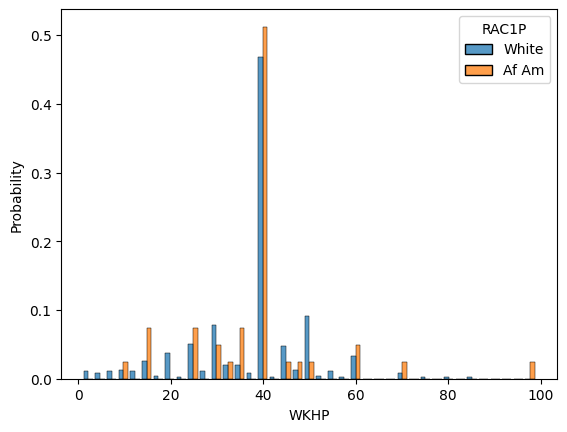

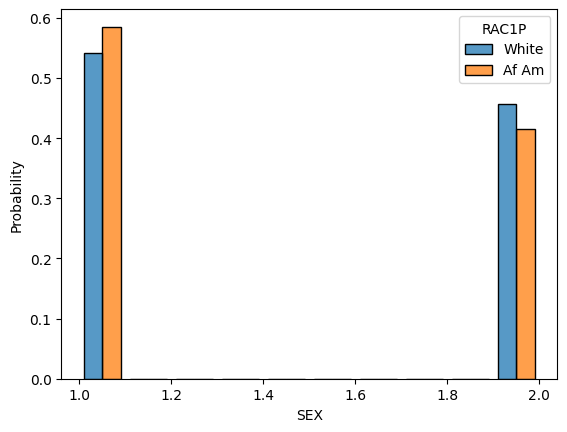

In [ ]:
for feature in X_train.drop(['RAC1P'], axis=1).columns:
    sns.histplot(data=X_train.assign(RAC1P=np.where(X_train['RAC1P'] == 1, 'White', 'Af Am')), x=feature, hue='RAC1P', multiple="dodge", common_norm=False, shrink=0.8, stat='probability')
    plt.show()

## Task 2

In [31]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)
### groups now contain information about SEX and RAC1P
features.head()

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,SEX_Male,RAC1P_Black or African American alone,RAC1P_White alone
0,21.0,20.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,65.0,8.0,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,33.0,40.0,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,18.0,18.0,106.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27.0,50.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [32]:
# Drop the "redundant" columns
features = features.drop(["RELP_Unmarried partner",
                          "CIT_U.S. citizen by naturalization",
                          "SEX_Male",
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm', 
                          "RAC1P_White alone" ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)

Columns with the protected features:
Column ID: 57 (SEX_Female)
Column ID: 58 (RAC1P_Black or African American alone)


In [33]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

N = 500 ### I am subsampling because it is slow on my machine

X_train = X_train[:N]
y_train = y_train[:N]
group_train = group_train[:N]
X_test = X_test[:N]
y_test = y_test[:N]
group_test = group_test[:N]

In [34]:
############
# YOUR CODE
############

#### Task 2.2.
Use the following arguments in the `opt.fmin_funct`: `xtol=1e-4, ftol=1e-4,  maxfun=1000`

In [35]:
gammas = np.logspace(1e-5,1e-2,10)
###########
# YOUR CODE
###########

#### Task 2.3
Use the following arguments in the `opt.fmin_funct`: ` xtol=1e-3, ftol=1e-3, approx_grad=True, maxfun=1000`

In [36]:
lambdas = np.array([1e-3, 5e-3, 1e-2, 5e-2, 0.1, 1])
###########
# YOUR CODE
###########